Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# NASBench-101

This colab accompanies [**NAS-Bench-101: Towards Reproducible Neural Architecture Search**](https://arxiv.org/abs/1902.09635) and the rest of the code at https://github.com/google-research/nasbench.

In this colab, we demonstrate how to use the dataset for simple benchmarking and analysis. The publicly available and free hosted colab instances are sufficient to run this colab.

## Load NAS-Bench-101 library and dataset

In [ ]:
%tensorflow_version 1.x
!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

from nasbench import api

nasbench = api.NASBench('nasbench_only108.tfrecord')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0   233M      0  0:00:02  0:00:02 --:--:--  233M
fatal: destination path 'nasbench' already exists and is not an empty directory.
Processing ./nasbench
  Created wheel for nasbench: filename=nasbench-1.0-cp37-none-any.whl size=46788 sha256=ee455463e243823678d5fa25532225550de0947b371538ec25fe125ca0dd0024
  Stored in directory: /tmp/pip-ephem-wheel-cache-hqz3sea0/wheels/4b/19/99/1d5fdfe30f8b16fab91e900808f4f7e5adc38e602c84970ad5
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=4c149a257eff3fb863ee3698abba25c2751067706d34084c750d88928d0dba26
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built nasbench gast
  Found existing installation: nasbench 1.0
    Uninstalling nasbench-

In [ ]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

## Basic usage

In [ ]:
# Query an Inception-like cell from the dataset.
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 0, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output']
trainable_parameters: 2040231
training_time: 1049.35205078125
train_accuracy: 1.0
validation_accuracy: 0.926682710647583
test_accuracy: 0.9168669581413269


In [ ]:
def fitness(solution):
  spec = api.ModelSpec(matrix=solution.matrix, ops=solution.ops)
  if nasbench.is_valid(spec):
    metrics = nasbench.query(spec)
    return metrics['validation_accuracy']
  else:
    return 0

def call_counter(fn):
    # hierarchical function to count number of evaluation calls
    def helper(*args, **kwargs):
        helper.calls += 1
        cur_val = fn(*args, **kwargs)
        if(cur_val > helper.best_val):
          helper.best_val = cur_val
          print('Best Val:{}, Func Eval:{}'.format(helper.best_val, helper.calls))
        
        return cur_val
    helper.__name__ = fn.__name__
    helper.calls = 0
    helper.best_val = float('-inf')
    return helper

fitness = call_counter(fitness)

class Candidate():
  def __init__(self, matrix, ops):
    self.matrix = matrix
    self.ops = ops

In [ ]:
def mutation(solution, mutation_rate=1.0):
  while True:
    new_matrix = solution.matrix.copy()
    new_ops = solution.ops.copy()

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
       
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
    
    # print('new_matrix')
    # print(np.shape(new_matrix))
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return Candidate(new_matrix, new_ops)

def crossover(parent1, parent2):
  child1_mat = np.zeros((NUM_VERTICES, NUM_VERTICES),dtype=int)
  child1_ops = []
  child2_mat = np.zeros((NUM_VERTICES, NUM_VERTICES),dtype=int)
  child2_ops = []
  cross_point = np.random.randint(NUM_VERTICES-2)+1
  
  for i in range(NUM_VERTICES):
    if i<cross_point:
      child1_ops.append(parent1.ops[i])
      child1_mat[:,i] = parent1.matrix[:,i]
      child2_ops.append(parent2.ops[i])
      child2_mat[:,i] = parent2.matrix[:,i]

    else:
      child1_ops.append(parent2.ops[i])
      child1_mat[:,i] = parent2.matrix[:,i]
      child2_ops.append(parent1.ops[i])
      child2_mat[:,i] = parent1.matrix[:,i]

  child1 = Candidate(child1_mat, child1_ops)
  child2 = Candidate(child2_mat, child2_ops)
  return child1, child2


def selection(population, objective):
    # function to perform tournament selection
    K = 5
    num_pop = len(population)
    perm = np.random.permutation(num_pop)
    pop_comb = perm[0:K]
    tournament_fit = np.zeros(K)

    # creating tournament population
    for i in range(K):
        tournament_fit[i] = objective[pop_comb[i]]

    # declaring winners
    idx = np.argsort(tournament_fit)
    parent_id1 = idx[0] 
    parent_id2 = idx[1]
    return parent_id1, parent_id2

def initialization(pop_size):
  # function for initialization
    population = []
    for pop_no in range(pop_size):
      matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
      matrix = np.triu(matrix, 1)
      ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
      ops[0] = INPUT
      ops[-1] = OUTPUT
      population.append(Candidate(matrix, ops))

    return population

In [ ]:
def GA(pop_size=50, num_gen=100, max_cross=10, cross_mut_prob=0.5):
  # main driver function for GA
  population = initialization(pop_size)
  obj_values = np.zeros(pop_size)
  avg_values = np.zeros(num_gen)

  for pop_no in range(pop_size):
    # calculate fitness for all the chromosomes
    obj_values[pop_no] = fitness(population[pop_no])

  for gen_no in range(num_gen):
    avg_values[gen_no] = np.mean(obj_values)
 
    for i in range(max_cross):
      if(np.random.rand()<cross_mut_prob):

        # parent selection
        parent_id1, parent_id2 = selection(population, obj_values)

        # crossover
        child_1, child_2 = crossover(population[parent_id1], population[parent_id2])

        # mutation
        child_1 = mutation(child_1)
        child_2 = mutation(child_2)

        # child fitness computation
        obj_1 = fitness(child_1)
        obj_2 = fitness(child_2)
        
        # child replaces the worst solution if applicable
        if(obj_1 > min(obj_values)):
            idx = np.argmin(obj_values)
            population[idx] = child_1
            obj_values[idx] = obj_1
            
        if(obj_2 > min(obj_values)):
            idx = np.argmin(obj_values)
            population[idx] = child_2
            obj_values[idx] = obj_2

  return avg_values

In [ ]:
pop_size=50
num_gen=100
cross_mut_prob=0.5
num_runs = 30
max_cross = 10

avg_val_plot = np.zeros((num_runs, num_gen))

for i in range(num_runs):
  avg_val_plot[i,:] = GA(pop_size=pop_size, num_gen=num_gen, max_cross=max_cross, cross_mut_prob=cross_mut_prob)

Best Val:0.9490184187889099, Func Eval:5625
Best Val:0.9504206776618958, Func Eval:14764
Best Val:0.9511218070983887, Func Eval:16516
Best Val:0.9518229365348816, Func Eval:29781


Text(0, 0.5, 'Average Fitness Score')

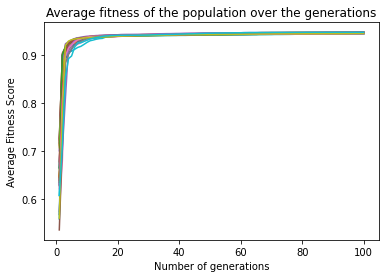

In [ ]:
from matplotlib import pyplot as plt 

X = list(range(1, num_gen+1))
Y = avg_val_plot
# print(Y[1])
for i in range(num_runs):
  plt.plot(X, Y[i,:])

plt.title('Average fitness of the population over the generations')
plt.xlabel('Number of generations')
plt.ylabel('Average Fitness Score')